# Lecture 04  
### Python Performance Tuning   
### February 15, 2023


fastest way to solve Ax=b
don't do A^(-1) expensive
use gaussian elimanation LUX=b

### Diagnosing and solving performance issues with profiling

https://nyu-cds.github.io/python-performance-tuning/

Install line_profiler: `conda install line_profiler`

### What is profiling?

* A *profile* is a set of statistics describing how often and for how long various parts of a program run
* Useful for identifying performance bottlenecks that could be optimized
* Profiling can induce a performance overhead (but relatively small in Python)

## Profiling in Python

**cProfile**: measures number of function calls and their execution time (in the function itself, including sub-calls or not)

**line_profiler**: measures number of executions and time for individual lines/statements (useful when individual statements could be slow, e.g., with Numpy)

### Monte Carlo Simultations for $\pi$ 

Suppose we want to approximate $\pi$ by using the following Monte Carlo simulations based on the geometric probability:
**review**: https://www.notion.so/L5-Gibbs-sampling-48a657d1245c46b59bb8d512673367bd?pvs=4#d59c67c2f11b4ba58e92fdbeae78d255

--- 

Plot the $1/4$-of the unit circle: $(x, \sqrt{1 - x^2})$ over the segment $[0, 1]$.

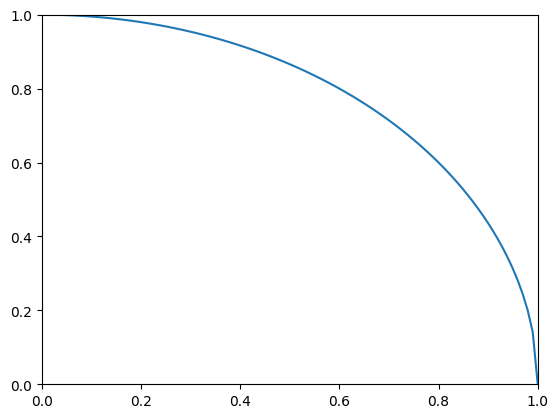

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# plot a quarter of the unit circle
x = np.linspace(0, 1.0, 100)
plt.plot(x, (1 - x ** 2) ** 0.5)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

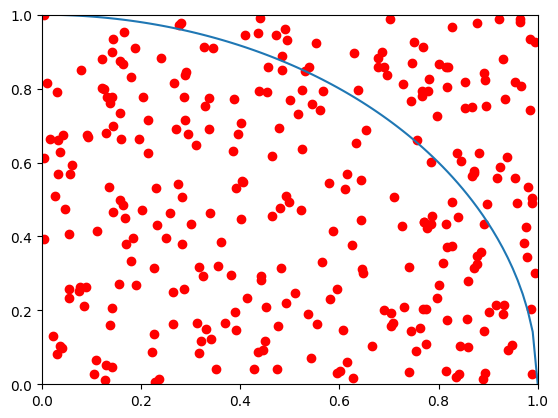

In [2]:
#plot random points

number_of_points = 300
plt.plot(np.random.random(number_of_points), np.random.random(number_of_points), 'ro')

# plot a quarter of the unit circle
x = np.linspace(0, 1.0, 100)
plt.plot(x, np.sqrt(1 - x ** 2))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

### Prob(a ranodm point belongs to the 1/4-unit-circle) = Area(1/4-unit-circle)/Area(unit-square) = Pi/4

In [3]:
import random
    
def inside_quarter_circle(x, y):
    """indicator that (x,y) belongs to the quarter of the circle"""
    return int(x ** 2 + y ** 2 <= 1.0)


# what to improve?
# 1. reduce func call
# 2. turn loop to comprehension(eg. pandas)

def approx_pi_mc(number_of_points):
    """monte-carlo PI"""
    
    counter = 0
    
    for i in range(number_of_points):
        x = random.random()
        y = random.random()
        counter += inside_quarter_circle(x, y)
        
    pi_approx = 4 * counter / number_of_points 
    print("pi_approx:", pi_approx)
    return pi_approx

In [4]:
%timeit -n 1 -r 1 approx_pi_mc(1_000_000)

pi_approx: 3.140728
539 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [5]:
# cProfile and profile provide deterministic profiling
import cProfile
cProfile.run('approx_pi_mc(1_000_000)')

pi_approx: 3.14344
         3000041 function calls in 0.798 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.369    0.369    0.798    0.798 3495656265.py:12(approx_pi_mc)
  1000000    0.313    0.000    0.313    0.000 3495656265.py:3(inside_quarter_circle)
        1    0.000    0.000    0.798    0.798 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 iostream.py:203(schedule)
        4    0.000    0.000    0.000    0.000 iostream.py:444(_is_master_process)
        4    0.000    0.000    0.000    0.000 iostream.py:465(_schedule_flush)
        4    0.000    0.000    0.000    0.000 iostream.py:535(write)
        1    0.000    0.000    0.000    0.000 iostream.py:90(_event_pipe)
        1    0.000    0.000    0.000    0.000 socket.py:613(send)
        1    0.000    0.000    0.000    0.000 threading.py:1017(_wait_for_tstate_lock)
        1    0.000    0.000    0.000    0.000 threading.py:1071(is_aliv

In [6]:
# run a code with the profiler
%prun approx_pi_mc(1_000_000)

pi_approx: 3.140636
 

Sometimes the cause of the hotspot is a single line in a function, which may not be obvious from reading the source code or analyzing the output of cProfile.

The __line_profiler__ times the execution of each individual line inside a function. The __line_profiler__ can be used by loading in Jupyer as:

In [10]:
# !pip install line-profiler
%load_ext line_profiler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.8/96.8 kB 1.4 MB/s eta 0:00:00a 0:00:01


In [14]:
# run code with the line-by-line profiler
# get the info of each lines in script
%lprun -f approx_pi_mc approx_pi_mc(1_000_000)
# Timer unit: 1e-09 s means vals in table/unit
# % Time: percentage of time for all
# -f : tells which function to profile

pi_approx: 3.141828


In [12]:


def approx_pi_mc_faster(total_number):
    
    # generate a vector of random points
    random_vect = np.random.rand(total_number, 2) # generate random # at once
    
    # check if points belong to the circle
    bool_inside = random_vect[:, 0] ** 2 + random_vect[:, 1] ** 2 <= 1
    
    # count those
    # counter = sum(bool_inside)
    counter = np.sum(bool_inside) # , dtype=np.int32
    
    pi_approx = 4 * counter / total_number 
    print("pi_approx:", pi_approx)
    return pi_approx

In [15]:
# %prun approx_pi_mc_faster(1_000_000)

%lprun -f approx_pi_mc_faster approx_pi_mc_faster(1_000_000)


pi_approx: 3.13816


In [16]:
tmp = random.random()
print(tmp.__abs__())
dir(tmp)  ## all the methods
# random.random() is slow -> because it's an object, you get much more attr
# generate in numpy will be faster

0.6012515211584902


['__abs__',
 '__add__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getformat__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__le__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__round__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__set_format__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__trunc__',
 'as_integer_ratio',
 'conjugate',
 'fromhex',
 'hex',
 'imag',
 'is_integer',
 'real']

## Performance Tuning -- Line Profiling  

#### Example: Heat Equation

#### How does the heat transfer?   

#### Finite Element Methods


Consider a function (concretely temperature) $f = f(x, y, t)$ which depends on $(x,y) \in [0,1] \times [0,1]$ and time $t \geq 0$. 

Temperature satisfies the __heat equation__ (https://en.wikipedia.org/wiki/Heat_equation):
$$
\frac{\partial f}{\partial t} = \alpha^2 \left(\frac{\partial^2 f}{ \partial x^2} + \frac{\partial^2 f}{ \partial y^2} \right) \,.
$$

The rate at which the temperature changes $\frac{\partial f}{\partial t}$ is proportional to the 
Laplacian of the temperature function $\left(\frac{\partial^2 f}{ \partial x^2} + \frac{\partial^2 f}{ \partial y^2} \right)$.

In steady state $\partial f/\partial t = 0$, so (the __Poisson equation__):
$$
\frac{\partial^2 f}{\partial x^2}+\frac{\partial^2 f}{\partial y^2}=0.
$$

By using central difference in a square $[0,1]\times[0,1]$ regular grid:
$$
\frac{\partial^2 f}{\partial x^2}\approx\frac{f_{i+1,j}-2f_{i,j}+f_{i-1,j}}{\Delta x^2}\,,
$$

$$
\frac{\partial^2 f}{\partial y^2}\approx\frac{f_{i,j+1}-2f_{i,j}+f_{i,j-1}}{\Delta y^2}\,.
$$

We will assume $\Delta x = \Delta y$, so it follows:
$$
f_{i,j} = \frac{f_{i+1,j}+f_{i-1,j} + f_{i,j+1} + f_{i,j-1}}{4} \,.
$$

We will also assume that $f$ is known on the boundary of the square domain.

In PC, every Q is a discrete Q

$\Delta x, \Delta y$ are the grid size

Take the avg of the surrounding 4 points(NEWS) to approximate $f_i,j$

In [20]:
from itertools import product
import numpy as np

def build_grid(n):
    '''defines the grid'''
    G = np.zeros((n, n))  # n=number of grid -> more grid better
    return G

def set_boundary_grid(G):
    '''set the boundary values'''
    n = G.shape[0]
    G[:, 0]  = np.ones((1, n))
    G[0, :]  = np.ones((1, n)) 
    G[-1, :] = np.ones((1, n))
    G[:, -1] = np.ones((1, n))
    

In [21]:
import matplotlib.pyplot as plt

def plot_grid(G):
    img = plt.imshow(G)
    img.set_cmap('rainbow')
    plt.axis('off')
    plt.show()
    

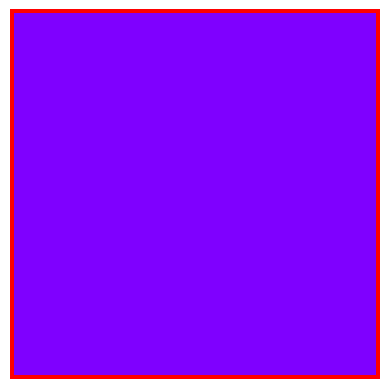

In [22]:
size_of_grid = 100

G = build_grid(n=size_of_grid)
set_boundary_grid(G)
plot_grid(G)    

In [37]:
# using two-loops
def iteration_loops(G):
    n = G.shape[0]
    for i in range(1, n-1):     # only update the one in betwee, not the boundary
        for j in range(1, n-1):
            # calculate the average
            G[i, j] = (G[i + 1, j] + G[i - 1, j] + G[i, j + 1] + G[i, j - 1]) / 4    


# using iterators to traverse the grid
def iteration_gen(G):
    n = G.shape[0]
    indices = product(range(1, n-1), repeat=2)
    for e in indices:
        G[e]=(G[e[0] + 1, e[1]] + G[e[0] - 1, e[1]] + G[e[0], e[1] + 1] + G[e[0], e[1] - 1])/4
    

In [38]:
# auxiliary functions:

# calculate error between G1 and G2
def calc_error(G1, G2):
    error = 0
    n = G1.shape[0]
    for i in range(n):
        for j in range(n):
            error += (G1[i, j] - G2[i, j]) ** 2     # may stop when no improving in gradient descent
    # normalize the error
    return error / n**2


# using numpy built-in functions to compute the error
# much faster
def calc_error_np(G1, G2):
    error = np.square(np.subtract(G1, G2)).mean()
    return error


# DEEP copy of G1 to G2
# won't copy if G1=G2, only update a pointer
def copy_array(G1, G2):
    G2[:, :] = G1[:, :]


In [39]:
def solve_heat_equation1(n):
    G = build_grid(n)
    set_boundary_grid(G)
    
    G_prev = build_grid(n)
    copy_array(G, G_prev)

    error = np.float("inf")
    while error > 1e-7:
        iteration_loops(G)
        error = calc_error(G, G_prev)
        copy_array(G, G_prev)         
    return G

In [40]:
%lprun -f solve_heat_equation1 G1 = solve_heat_equation1(size_of_grid)

/var/folders/b0/ynvysx9d57l7xwhy17df8dxh0000gn/T/ipykernel_3998/2470477744.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.float("inf")


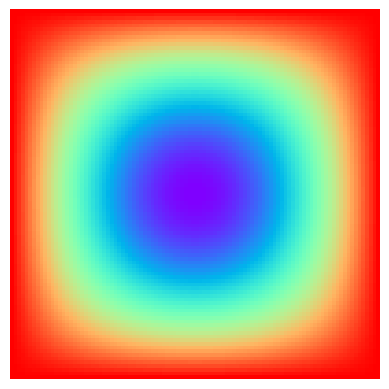

In [41]:
plot_grid(G1)

In [50]:
def solve_heat_equation2(n):
    '''changing to calc_error_np function'''
    G = build_grid(n)
    set_boundary_grid(G)
    
    G_prev = build_grid(n)
    copy_array(G, G_prev)
    
    error = np.float("inf")
    while error > 1e-7:
        iteration_loops(G)
        error = calc_error_np(G,G_prev) 
        copy_array(G,G_prev)    
        
    return G

In [51]:
%lprun -f solve_heat_equation2 G2 = solve_heat_equation2(size_of_grid)

/var/folders/b0/ynvysx9d57l7xwhy17df8dxh0000gn/T/ipykernel_3998/2060385761.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.float("inf")


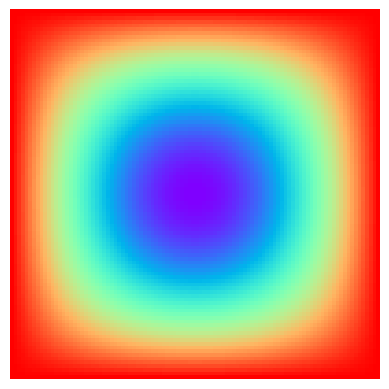

In [44]:
plot_grid(G2)

In [45]:
def solve_heat_equation3(n):
    '''changing to iteration_gen function'''
    G = build_grid(n)
    set_boundary_grid(G)
    
    G_prev = build_grid(n)
    copy_array(G, G_prev)
    
    error = np.float("inf")
    while error > 1e-7:
        iteration_gen(G)
        error = calc_error(G,G_prev) 
        copy_array(G, G_prev)    
        
    return(G)

In [46]:
%lprun -f solve_heat_equation3 G3 = solve_heat_equation3(size_of_grid)

/var/folders/b0/ynvysx9d57l7xwhy17df8dxh0000gn/T/ipykernel_3998/1394998455.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.float("inf")


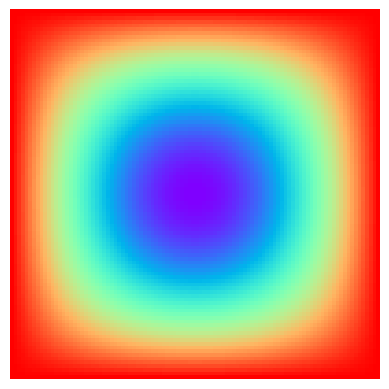

In [30]:
plot_grid(G3)

In [47]:
def solve_heat_equation4(n):
    '''changing to both calc_error_np and iteration_gen functions'''
    G = build_grid(n)
    set_boundary_grid(G)
    
    G_prev = build_grid(n)
    copy_array(G, G_prev)
    
    error = np.float("inf")
    while error > 1e-7:
        iteration_gen(G)
        error = calc_error_np(G, G_prev) 
        copy_array(G, G_prev)          
    return G

In [49]:
%lprun -f solve_heat_equation4 G4 = solve_heat_equation4(size_of_grid)

/var/folders/b0/ynvysx9d57l7xwhy17df8dxh0000gn/T/ipykernel_3998/3856288979.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.float("inf")


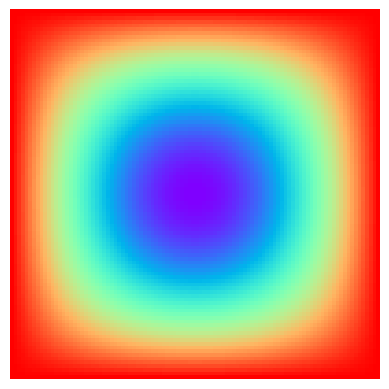

In [52]:
plot_grid(G4)

In [53]:
# different update (synchronous instead of asynchronous) but using only numpy
# use the formula: fastest but not generalizable to other Q.
def iteration_np(G):
    n = G.shape[0]
    G[1:n-1,1:n-1] = (G[:n-2,1:n-1] + G[2:,1:n-1] + G[1:n-1,:n-2] + G[1:n-1,2:]) / 4

In [54]:
def solve_heat_equation5(n):
    '''all using numpy'''
    G = build_grid(n)
    set_boundary_grid(G)
    
    G_prev = build_grid(n)
    copy_array(G, G_prev)
    
    error = np.inf
    while error > 1e-7:
        iteration_np(G)
        error = calc_error_np(G, G_prev)
        copy_array(G, G_prev)
    return G

In [55]:
%lprun -f solve_heat_equation5 G5 = solve_heat_equation5(size_of_grid)

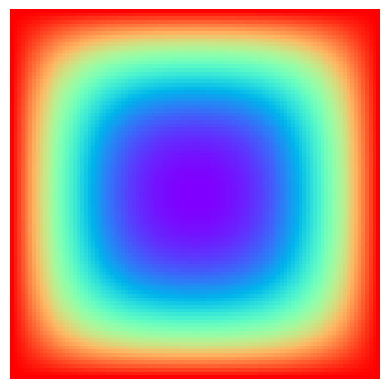

In [56]:
plot_grid(G5)